In [1]:
from dotenv import  load_dotenv
from langchain_openai import ChatOpenAI

load_dotenv()

llm = ChatOpenAI(model='gpt-4o')
small_llm = ChatOpenAI(model='gpt-4o-mini')

In [2]:
from langchain_community.tools import DuckDuckGoSearchRun

search_tool = DuckDuckGoSearchRun() 

In [ ]:
from langchain_google_community import GmailToolkit
from langchain_google_community.gmail.utils import (build_resource_service, get_gmail_credentials)

credentials = get_gmail_credentials(
    token_file="./google/token.json",
    scopes=["https://mail.google.com/"],
    client_secrets_file="./google/gmail_credentials.json"
)

api_resource = build_resource_service(credentials=credentials)

gmail_toolkit = GmailToolkit(api_resource=api_resource)

gmail_tool_list = gmail_toolkit.get_tools()



[GmailCreateDraft(api_resource=<googleapiclient.discovery.Resource object at 0x137fae2d0>),
 GmailSendMessage(api_resource=<googleapiclient.discovery.Resource object at 0x137fae2d0>),
 GmailSearch(api_resource=<googleapiclient.discovery.Resource object at 0x137fae2d0>),
 GmailGetMessage(api_resource=<googleapiclient.discovery.Resource object at 0x137fae2d0>),
 GmailGetThread(api_resource=<googleapiclient.discovery.Resource object at 0x137fae2d0>)]

In [ ]:
from langchain_classic.agents import load_tools

loaded_tool_list = load_tools(
    ["arxiv"]
)



[ArxivQueryRun(api_wrapper=ArxivAPIWrapper(arxiv_search=<class 'arxiv.Search'>, arxiv_exceptions=(<class 'arxiv.ArxivError'>, <class 'arxiv.UnexpectedEmptyPageError'>, <class 'arxiv.HTTPError'>), top_k_results=3, ARXIV_MAX_QUERY_LENGTH=300, continue_on_failure=False, load_max_docs=100, load_all_available_meta=False, doc_content_chars_max=4000))]

In [5]:
from langchain_chroma import Chroma
from langchain_openai import OpenAIEmbeddings
from langchain_core.tools.retriever import create_retriever_tool


embeddings = OpenAIEmbeddings(model='text-embedding-3-large')

vector_store = Chroma(
    embedding_function = embeddings,
    collection_name = 'real_estate_tax2',
    persist_directory = './real_estate_tax_collection2'
)
retriever = vector_store.as_retriever(search_kwargs={'k':3})


retriever_tool = create_retriever_tool(
    retriever=retriever,
    name='real_estate_tax_retreiver',
    description='Contains information about real estate tax up to December 2025'
)

In [ ]:
from langgraph.prebuilt import ToolNode

tool_list = [ search_tool, retriever_tool] + gmail_tool_list + loaded_tool_list

llm_with_tools = llm.bind_tools(tool_list)  

tool_node = ToolNode(tool_list) 


In [116]:
from langgraph.graph import MessagesState, StateGraph

class AgentState(MessagesState):
    summary: str

graph_builder = StateGraph(AgentState)

In [117]:
from langchain_core.messages import SystemMessage

def agent(state: AgentState):
    messages = state['messages']
    summary = state['summary']
    
    if summary != '':
        messages = [SystemMessage(content=f'Here is the sumary of the earlier conversation: {summary}')] + messages
    
    response = llm_with_tools.invoke(messages)
    
    print(f'message length == {len(messages)}')
    return {'messages': [response]}

In [118]:
def summarize_messages(state: AgentState):
    messages = state['messages']
    summary = state['summary']
    
    summary_prompt = f'summarize this chat history below: \n\n chat history: {messages}'
    
    if summary != '':
        summary_prompt = f'''summarize this chat history below while looking at the summary of earlier conversations
                            chat_history: {messages}
                            summary: {summary}'''
        
    summary = small_llm.invoke(summary_prompt)
    response = llm_with_tools.invoke(messages)
    return {'summary': response.content}

In [119]:
from langchain_core.messages import RemoveMessage #
    
def delete_messages(state: AgentState):
    messages = state['messages']
    left_messages = [RemoveMessage(id=message.id) for message in messages[:-3]] 
    return {'messages': left_messages}

In [120]:
def should_continue(state: AgentState):
    messages = state['messages']
    last_ai_message = messages[-1]
    
    if last_ai_message.tool_calls:
        return 'tools'
    return 'summarize'

In [121]:
graph_builder.add_node('tool_node',tool_node)
graph_builder.add_node(agent)
graph_builder.add_node(delete_messages)
graph_builder.add_node(summarize_messages)

In [122]:
from langgraph.graph import START, END

graph_builder.add_edge(START, 'agent')

graph_builder.add_conditional_edges(
    'agent',
    should_continue,
    {
        'tools': 'tool_node',
        'summarize': 'summarize_messages'
    },
)

graph_builder.add_edge('tool_node', 'agent')
graph_builder.add_edge('summarize_messages', 'delete_messages')
graph_builder.add_edge('delete_messages', END)

In [123]:
from langgraph.checkpoint.memory import MemorySaver

checkpointer = MemorySaver() #

graph = graph_builder.compile(checkpointer=checkpointer) 

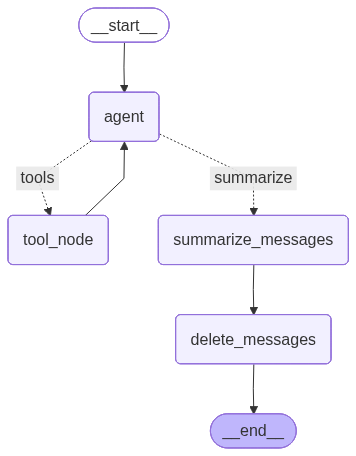

In [124]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [125]:
from langchain_core.messages import HumanMessage

config = {
    'configurable': {
        'thread_id': 'paper_summary'
    }
}

query='please Summarize the Conclusion part of `attention Is All You Need` and Write a draft to ksz18601@gmail.com'

for chunk in graph.stream({'messages': [HumanMessage(query)], 'summary':''}, stream_mode='values', config=config): # 
    chunk['messages'][-1].pretty_print()

================================ Human Message =================================

please Summarize the Conclusion part of `attention Is All You Need` and Write a draft to ksz18601@gmail.com
message length == 1
================================== Ai Message ==================================
Tool Calls:
  arxiv (call_mqLHktnsE2VnJBksPOpOfwU6)
 Call ID: call_mqLHktnsE2VnJBksPOpOfwU6
  Args:
    query: attention Is All You Need
================================= Tool Message =================================
Name: arxiv

Published: 2021-05-06
Title: Do You Even Need Attention? A Stack of Feed-Forward Layers Does Surprisingly Well on ImageNet
Authors: Luke Melas-Kyriazi
Summary: The strong performance of vision transformers on image classification and other vision tasks is often attributed to the design of their multi-head attention layers. However, the extent to which attention is responsible for this strong performance remains unclear. In this short report, we ask: is the attention layer e

In [126]:
update_query='and please Attach the URL of paper'

for chunk in graph.stream({'messages': [HumanMessage(update_query)],'summary':''}, stream_mode='values', config=config): 
    chunk['messages'][-1].pretty_print()

================================ Human Message =================================

and please Attach the URL of paper
message length == 4
================================== Ai Message ==================================
Tool Calls:
  create_gmail_draft (call_8LRF2HvRkgWv5Ulzt5t13M8A)
 Call ID: call_8LRF2HvRkgWv5Ulzt5t13M8A
  Args:
    message: Subject: Summary of 'Attention Is All You Need' Conclusion

Hi,

I hope this message finds you well. Below is a brief summary of the conclusion section from the seminal paper 'Attention Is All You Need.'

The paper concludes by highlighting the efficacy of the Transformer model, which relies solely on attention mechanisms, dispensing with recurrence entirely. The authors emphasize that the Transformer surpasses traditional models in terms of both performance and efficiency on translation tasks. They underscore the potential of attention mechanisms to improve various NLP tasks due to their ability to capture long-range dependencies without the need 

In [127]:
update_query='Okay, please Send it to ksz18601@gmail.com'

for chunk in graph.stream({'messages': [HumanMessage(update_query)], 'summary':''}, stream_mode='values', config=config): 
    chunk['messages'][-1].pretty_print()

================================ Human Message =================================

Okay, please Send it to ksz18601@gmail.com
message length == 4
================================== Ai Message ==================================
Tool Calls:
  send_gmail_message (call_hcnXedmAZKTW4IEoAN1gpfe6)
 Call ID: call_hcnXedmAZKTW4IEoAN1gpfe6
  Args:
    message: Subject: Summary of 'Attention Is All You Need' Conclusion

Hi,

I hope this message finds you well. Below is a brief summary of the conclusion section from the seminal paper 'Attention Is All You Need.'

The paper concludes by highlighting the efficacy of the Transformer model, which relies solely on attention mechanisms, dispensing with recurrence entirely. The authors emphasize that the Transformer surpasses traditional models in terms of both performance and efficiency on translation tasks. They underscore the potential of attention mechanisms to improve various NLP tasks due to their ability to capture long-range dependencies without t